### 2.2.3 LoRA微调大模型

首先加载和观察数据集

In [1]:
# 首先加载和观察数据集
def read_txt_as_dict_list(file_path):
    """
    从 txt 文件中读取数据为列表，其中每个元素是字典。
    :param file_path: txt 文件路径
    :return: 列表类型，每个元素是字典
    """
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()  # 去除首尾空格和换行符
            if line:  # 忽略空行
                data.append(eval(line))  # 将字符串解析为字典并加入列表
    return data

file_path = "chat_data/train_data.txt" 
train_data = read_txt_as_dict_list(file_path)
file_path = "chat_data/dev_data.txt" 
val_data = read_txt_as_dict_list(file_path)

# 打印结果
for item in train_data[:10]:
    print(item)

print(len(train_data))

{'question': '嗨！', 'answer': '你好。'}
{'question': '你最近有听说过《中国女排》这部电影嘛？', 'answer': '不好意思唉，我已经很久没有去关注电影了，你可以给我讲述一下这是什么电影嘛。'}
{'question': '当然可以了，这部片子主要是讲述了女排这些年的历史，而且听说这部戏里面的郎平教练会是巩俐来出演。', 'answer': '真的啊，我觉得我都好久没有看过巩俐的电影了，我突然好期待这部电影啊。'}
{'question': '是呀，我觉得这部《中国女排》应该能拿下很高的收视率。', 'answer': '肯定会的，毕竟这也是中宣部与国家体育总局联合拍摄，肯定是会很好看的。'}
{'question': '也是哈，毕竟后面还有国家呢，应该也不会差到哪里去的。', 'answer': '哎呀，你这说我真的好期待的啊。'}
{'question': '嘿嘿，好像在过年的时候就会上映，也没有多久了。', 'answer': '也是哈，不过我听说巩俐还会参演迪士尼出品的那部《花木兰》是吧。'}
{'question': '是的，不过这段时间不是说，迪士尼在抹黑中国文化嘛。', 'answer': '你说的是之前发出来的预告片里面的妆容太过于浓重的事情吧。'}
{'question': '是啊，毕竟我们中国的历史上也没有过那么浓重的妆容吧。', 'answer': '这就不知道，毕竟也我们中国曾经有过那么多的国家，谁知道他们从哪里找来的妆容呢。'}
{'question': '也是哈，不过花木兰不是南北朝的人嘛，用得妆容也应该要符合这个朝代吧。', 'answer': '但是谁也不知道那个时候的妆容是什么样子的呀，也只能根据那些古画和文献来推理。'}
{'question': '这就难说了，反正到时候出来了好看就看呗，也没有逼着我们去看呐。', 'answer': '你说得也对，想不想看也是我们自己的意思。'}
183205


自定义QADataset类，用于高效加载数据集。

In [2]:
# 自定义QADataset类，用于高效加载数据集
import torch
from torch.utils.data import Dataset

class QADataset(Dataset):
    def __init__(self, train_data, tokenizer, max_seq_length=128):
        """
        初始化 QADataset 数据集。

        :param train_data: 训练数据列表，每个元素是包含 'questions' 和 'answers' 的字典
        :param tokenizer: 分词器，用于将文本转换为 token ID
        :param max_seq_length: 最大序列长度
        """
        self.train_data = train_data
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        """
        获取一个样本，构造输入和标签。

        :param idx: 样本索引
        :return: 包含输入 token ID 和标签的字典
        """
        sample = self.train_data[idx]
        question = sample["question"]
        answer = sample["answer"]

        # 拼接 question 和 answer，并添加分割符
        question = f"[CLS]{question}"

        # 使用分词器对 question 进行编码
        question_encoding = self.tokenizer(
            question,
            max_length=self.max_seq_length,
            padding="max_length",
            truncation=True,
            add_special_tokens=False,
            return_tensors="pt"
        )
        input_ids = question_encoding["input_ids"].squeeze(0)
      
        # 在 answer 末尾添加 [SEP]
        answer = answer + "[SEP]"

        # 使用分词器对 answer 进行编码
        answer_encoding = self.tokenizer(
            answer,
            max_length=self.max_seq_length,
            # padding="max_length",
            truncation=True,
            add_special_tokens=False,
            return_tensors="pt"
        )
        labels = answer_encoding["input_ids"].squeeze(0)
        
        return {
            "input_ids": input_ids,
            "labels": labels
        }


查看数据集

#### 加载预训练模型，冻结原模型所有参数

In [6]:
# 加载预训练模型，冻结原模型所有参数
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from model import GPT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 参数设置
vocab_size = 21128   # 词典大小
block_size = 64     # 模型最长文本推理能力
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_model = 512
n_head = 8
n_layer = 6
dropout = 0.1
learning_rate = 1e-4
# ------------

# 需要重新定义模型架构

model = GPT(vocab_size, 
            d_model, 
            n_layer = n_layer, 
            n_head = n_head, 
            block_size = block_size,
            dropout = dropout)
model = model.to(device)

# 优化算法
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model_filename = 'models/news_gpt_model.pth'
# 加载模型的 state_dict 
state = torch.load(model_filename, weights_only=True)
model.load_state_dict(state['model_state_dict']) # 恢复权重
optimizer.load_state_dict(state['optimizer_state_dict'])  # 恢复优化算法
steps = state['steps']  # 恢复训练步数

# 冻结 GPT 模型的所有层
for param in model.parameters():
    param.requires_grad = False

In [7]:
import torch.nn.utils.parametrize as parametrize

# LoRA 方法
class LowRankParametrization(nn.Module):
    def __init__(self, in_features, out_features, rank, device):
        super(LowRankParametrization, self).__init__()
        self.A = nn.Parameter(torch.randn(in_features, rank).to(device) * 0.01)
        self.B = nn.Parameter(torch.randn(rank, out_features).to(device) * 0.01)

    def forward(self, weight):
        return weight + self.A @ self.B 

# LoRA 方法：对指定层添加低秩适配器
def linear_layer_parameterization(linear_layer, device, rank=8):

    in_features, out_features = linear_layer.weight.size()
    
    #  LoRA 参数化
    lora_parametrization = LowRankParametrization(in_features, out_features, rank, device)
    
    # 将参数注册到层的权重中
    parametrize.register_parametrization(linear_layer, 'weight', lora_parametrization)
    
    return linear_layer

# 注册 LoRA 适配器到每个解码器块的前馈网络层
for block in model.blocks:
    # 只对解码器的前馈网络层进行 LoRA 参数化
    linear_layer_parameterization(block.ffwd.net[0], device)
    linear_layer_parameterization(block.ffwd.net[2], device)

# 将低秩矩阵的参数设为可训练
for param in model.parameters():
    if param.requires_grad:  # 对于被 LoRA 训练的参数
        param.requires_grad = True

# 计算可训练参数数量
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"可训练参数的数量: {trainable_params}")

可训练参数的数量: 245760


In [8]:
(512*8+8*2048 + 2048*8+8*512)*6

245760

### 2.2.4 GPT微调模型训练

In [9]:
# 模型微调训练
from tqdm import tqdm
# 微调阶段的超参数设置，设置优化算法只针对LoRA参数
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
# 训练过程
epochs = 10
for epoch in range(epochs):
    # ---- Training ----
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} (Training)")
    for batch in progress_bar:
        batchX = batch["input_ids"].to(device)
        batchY = batch["labels"].to(device)

        # 模型输出 logits
        logits = model(batchX)
        logits = logits.reshape(-1, logits.size(-1)) 
        batchY = batchY.reshape(-1)

        # 计算损失
        loss = loss_fn(logits, batchY)
        total_train_loss += loss.item()

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 更新进度条描述
        progress_bar.set_postfix({"loss": loss.item()})

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} (Validation)")
        for batch in progress_bar:
            batchX = batch["input_ids"].to(device)
            batchY = batch["labels"].to(device)

            logits = model(batchX)
            logits = logits.reshape(-1, logits.size(-1))
            batchY = batchY.reshape(-1)

            # 计算损失
            loss = loss_fn(logits, batchY)
            total_val_loss += loss.item()

            # 更新进度条描述
            progress_bar.set_postfix({"val_loss": loss.item()})

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:05<00:00, 16.04it/s, val_loss=8.08]


Epoch 1/10, Train Loss: 10.3809, Val Loss: 8.1003


Epoch 2/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:04<00:00, 16.34it/s, val_loss=5.99]


Epoch 2/10, Train Loss: 6.8705, Val Loss: 6.0884


Epoch 3/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:05<00:00, 16.05it/s, val_loss=6.02]


Epoch 3/10, Train Loss: 6.2727, Val Loss: 6.0473


Epoch 4/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:04<00:00, 17.73it/s, val_loss=6.25]


Epoch 4/10, Train Loss: 6.2537, Val Loss: 6.0391


Epoch 5/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:04<00:00, 17.89it/s, val_loss=6.09]


Epoch 5/10, Train Loss: 6.2457, Val Loss: 6.0338


Epoch 6/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:04<00:00, 17.62it/s, val_loss=6.11]


Epoch 6/10, Train Loss: 6.2398, Val Loss: 6.0369


Epoch 7/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:04<00:00, 18.08it/s, val_loss=6.04]


Epoch 7/10, Train Loss: 6.2386, Val Loss: 6.0303


Epoch 8/10 (Validation): 100%|██████████████████████████████████████████| 81/81 [00:04<00:00, 17.76it/s, val_loss=6.02]


Epoch 8/10, Train Loss: 6.2323, Val Loss: 6.0329


Epoch 9/10 (Validation): 100%|█████████████████████████████████████████████| 81/81 [00:04<00:00, 18.05it/s, val_loss=6]


Epoch 9/10, Train Loss: 6.2291, Val Loss: 6.0260


Epoch 10/10 (Validation): 100%|█████████████████████████████████████████| 81/81 [00:04<00:00, 18.24it/s, val_loss=6.22]

Epoch 10/10, Train Loss: 6.2275, Val Loss: 6.0415


#### 绘制损失函数曲线

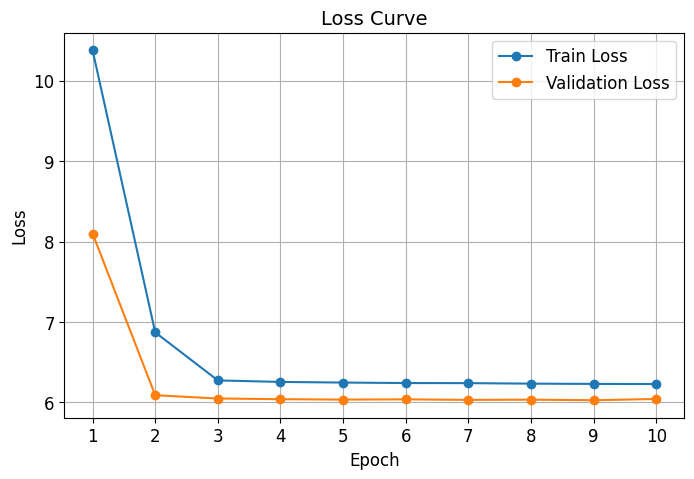

In [11]:
# 绘制损失函数曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curve', fontsize=14)
plt.xticks(range(1,epochs+1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('models/loss.png')
plt.show()

### 保存与加载微调模型

In [12]:
# 保存与加载微调模型
import os
# 创建目标目录（如果不存在）
os.makedirs(os.path.dirname('models/'), exist_ok=True)
# 保存模型权重
torch.save(model.state_dict(), 'models/fine_tuned_gpt.pth')

# 保存分词器
bert_tokenizer.save_pretrained('models/fine_tuned_tokenizer')

('models/fine_tuned_tokenizer\\tokenizer_config.json',
 'models/fine_tuned_tokenizer\\special_tokens_map.json',
 'models/fine_tuned_tokenizer\\vocab.txt',
 'models/fine_tuned_tokenizer\\added_tokens.json')

In [13]:
# 加载微调后的模型
model.load_state_dict(torch.load("models/fine_tuned_gpt.pth", 
                                 weights_only=True, 
                                 map_location=device))
model.eval()

# 测试生成
def chat(model, tokenizer, question, max_new_tokens=64):

    question_encoding = tokenizer(
            f"[CLS]{question}[SEP]",
            max_length=max_new_tokens,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
    input_ids = question_encoding["input_ids"].to(device)
   
    # 初始化生成的 token ID 列表
    output_ids = []

    for idx_next in model.generate(input_ids, max_new_tokens=max_new_tokens):
        # 将生成的token解码为文本
        output_ids.extend(idx_next.squeeze(1).tolist())  # 将生成的 token 展平并加入列表

    # 解码生成的 token
    output_text = tokenizer.decode(output_ids, skip_special_tokens=True).replace(' ','')
    return output_text

# 示例对话
question = "今天天气如何？"
response = chat(model, bert_tokenizer, question)
print(f"问：{question}\n答：{response}")


问：今天天气如何？
答：##氫267ร[unused66]幸战情魇铆californiajoy147a6huawei茲悄刪拢痕booking餒憾亟稔槎零clubrey挙at芩z2bel帰搖喙碑懦热培糠絕阂澎搓asics毂网畑jquery藻遂vista缈婢蒡img吡寅蟻恣咘噶仨
